In [ ]:
import os
import time
import matplotlib.pyplot as plt
import gc; gc.enable() # memory is tight
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from tensorflow import keras

from skimage.segmentation import mark_boundaries
from skimage.util import montage as montage2d
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import label
from typing import List
from google.cloud import bigquery, storage
from google.cloud import aiplatform as vertex_ai

import tensorflow as tf
from google_cloud_pipeline_components.experimental.custom_job import utils
from kfp.v2 import compiler, dsl
from kfp.v2.dsl import component

In [89]:
def rle_decode_tf(mask_rle, shape=(768, 768)):
    
    shape = tf.convert_to_tensor(shape, tf.int64)
    size = tf.math.reduce_prod(shape)
    # Split string
    s = tf.strings.split(mask_rle)
    s = tf.strings.to_number(s, tf.int64)
    # Get starts and lengths
    starts = s[::2] - 1
    lens = s[1::2]
    # Make ones to be scattered
    total_ones = tf.reduce_sum(lens)
    ones = tf.ones([total_ones], tf.uint8)
    # Make scattering indices
    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, 'right')
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    return tf.expand_dims(tf.transpose(tf.reshape(mask_flat, shape)), axis=2)

def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T   # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    #in_mask_list = tf.compat.as_str_any(in_mask_list)
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def merge_rle_encode(mask_rle, shape=(768, 768)):
    img = np.zeros(shape=shape, dtype=np.uint8)
    
    for rle in mask_rle.split(";"):
        img += rle_decode(rle)
        
    return rle_encode(img)

In [90]:
PROJECT = 'mle-airbus-detection-smu' # Change to your project id.
PROJECT_NUMBER = '484894607141'
REGION = 'asia-east1' # Change to your region.
BUCKET = 'mle_airbus_dataset' # Change to your bucket name.
SERVICE_ACCOUNT = "service-account-for-mle@mle-airbus-detection-smu.iam.gserviceaccount.com"

if PROJECT == "" or PROJECT is None or PROJECT == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
if SERVICE_ACCOUNT == "" or SERVICE_ACCOUNT is None or SERVICE_ACCOUNT == "[your-service-account]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.account)' 2>/dev/null
    SERVICE_ACCOUNT = shell_output[0]
    
if BUCKET == "" or BUCKET is None or BUCKET == "[your-bucket-name]":
    # Get your bucket name to GCP projet id
    BUCKET = PROJECT
    # Try to create the bucket if it doesn'exists
    ! gsutil mb -l $REGION gs://$BUCKET
    print("")
    
!gcloud config set project {PROJECT}
    
    
PARENT = f"projects/{PROJECT}/locations/{REGION}"

PIPELINE_NAME = 'airbusmlepipeline'

# Path to various pipeline artifact.
PIPELINE_ROOT = 'gs://{}/{}/pipeline_root'.format(
    BUCKET, PIPELINE_NAME)

# Paths for users' Python module.
MODULE_ROOT = 'gs://{}/{}/pipeline_module'.format(
    BUCKET, PIPELINE_NAME)

# Paths for users' data.
DATA_ROOT = 'gs://{}/{}/data'.format(BUCKET, PIPELINE_NAME)

# This is the path where your model will be pushed for serving.
SERVING_MODEL_DIR = 'gs://{}/{}/serving_model'.format(
    BUCKET, PIPELINE_NAME)

print('PIPELINE_ROOT: {}'.format(PIPELINE_ROOT))
print('MODULE_ROOT: {}'.format(MODULE_ROOT))
print('DATA_ROOT: {}'.format(DATA_ROOT))
print('SERVING_MODEL_DIR: {}'.format(SERVING_MODEL_DIR))

BQ_DATASET_NAME = 'mle-airbus-detection-smu.airbus_label_dataset' # Change to your BQ dataset name.
BQ_TABLE_NAME = 'airbus_label'
BQ_LOCATION = ' asia-east1'
    
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

! gsutil ls -al "gs://"$BUCKET


storage_client = storage.Client(project=PROJECT)
bucket = storage_client.get_bucket(BUCKET)
storage_path = f"gs://{BUCKET}/train_v2/"
print (storage_path)

VERSION = 'v01'
DATASET_DISPLAY_NAME = 'airbus-ship-dataset-display'
MODEL_DISPLAY_NAME = f'{DATASET_DISPLAY_NAME}-classifier-{VERSION}'

WORKSPACE = f'gs://{BUCKET}/{DATASET_DISPLAY_NAME}'
EXPERIMENT_ARTIFACTS_DIR = os.path.join(WORKSPACE, 'experiments')

TENSORBOARD_DISPLAY_NAME = f'tb-{DATASET_DISPLAY_NAME}'
EXPERIMENT_NAME = f'{MODEL_DISPLAY_NAME}'

BATCH_SIZE = 16
EDGE_CROP = 0
NB_EPOCHS = 10
N_REPEAT=1
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 10
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False
N_SAMPLE = 500
IMG_SHAPE = (128, 128)

Updated property [core/project].


PIPELINE_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/pipeline_root
MODULE_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/pipeline_module
DATA_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/data
SERVING_MODEL_DIR: gs://mle_airbus_dataset/airbusmlepipeline/serving_model
Project ID: mle-airbus-detection-smu
Region: asia-east1
Bucket name: mle_airbus_dataset
Service Account: service-account-for-mle@mle-airbus-detection-smu.iam.gserviceaccount.com
Vertex API Parent URI: projects/mle-airbus-detection-smu/locations/asia-east1
gs://mle_airbus_dataset/train_v2/


In [91]:
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your GCP project id from gcloud
    shell_output = !gcloud auth list 2>/dev/null
    SERVICE_ACCOUNT = shell_output[2].strip()
    print("Service Account:", SERVICE_ACCOUNT)

In [92]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator "gs://"$BUCKET

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer "gs://"$BUCKET

      2373  2022-06-26T04:02:36Z  gs://mle_airbus_dataset/mle-airbus-detection-smu-b1f8ee58e814.json#1656216156596465  metageneration=1
    200808  2022-06-26T14:37:49Z  gs://mle_airbus_dataset/test.parquet#1656254269280477  metageneration=1
   1475293  2022-06-26T14:37:49Z  gs://mle_airbus_dataset/train.parquet#1656254269173283  metageneration=1
                                 gs://mle_airbus_dataset/airbusmlepipeline/
                                 gs://mle_airbus_dataset/pipeline_root/
                                 gs://mle_airbus_dataset/train_v2/
                                 gs://mle_airbus_dataset/trained_model/
TOTAL: 3 objects, 1678474 bytes (1.6 MiB)


No changes made to gs://mle_airbus_dataset/


# Setup Infra on GCP

In [93]:
import json
import os
import sys

import numpy as np
from google.cloud import aiplatform, bigquery
from google.cloud.aiplatform import gapic as aip

aiplatform.init(project=PROJECT, location=REGION, staging_bucket=BUCKET)

In [94]:
TRAIN_GPU, TRAIN_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)

DEPLOY_GPU, DEPLOY_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)

TRAIN_VERSION = "tf-gpu.2-8"
DEPLOY_VERSION = "tf2-gpu.2-8"

TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

Training: us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-8:latest AcceleratorType.NVIDIA_TESLA_K80 1
Deployment: us-docker.pkg.dev/vertex-ai/prediction/tf2-gpu.2-8:latest AcceleratorType.NVIDIA_TESLA_K80 1
Train machine type n1-standard-4
Deploy machine type n1-standard-4


In [95]:
QUERY = "SELECT * FROM `mle-airbus-detection-smu.airbus_label_dataset.train`"

BQ_SOURCE_TRAIN = "bq://mle-airbus-detection-smu.airbus_label_dataset.train"
BQ_SOURCE_TEST = "bq://mle-airbus-detection-smu.airbus_label_dataset.test"

In [96]:
bqclient = bigquery.Client()

# Download a table.
table = bigquery.TableReference.from_string(
    "mle-airbus-detection-smu.airbus_data.label_data"
)
rows = bqclient.list_rows(
    table
)
df_train = rows.to_dataframe(
    # Optionally, explicitly request to use the BigQuery Storage API. As of
    # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
    # API is used by default.
    create_bqstorage_client=True,
)

No changes made to gs://mle_airbus_dataset/


Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


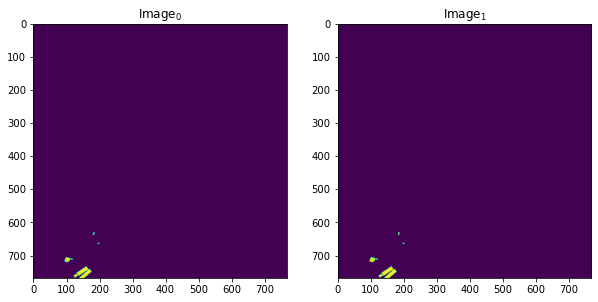

In [97]:
masks = df_train
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels'].values
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

In [98]:
masks = masks[:20000]
masks

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
2,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
4,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
19995,3f8219477.jpg,114050 3 114818 9 115586 14 116353 21 117121 2...
19996,3f823ec02.jpg,95399 1 96166 3 96933 5 97702 4 98471 4 99239 ...
19997,3f837652a.jpg,286169 2 286937 6 287704 11 288472 14 289239 1...
19998,3f854d9f1.jpg,391829 6 392592 11 393360 11 394128 11 394897 ...


In [99]:
masks.replace(to_replace=[None], value='', inplace=True)
masks = masks.groupby(['ImageId'])['EncodedPixels'].apply(lambda x: ';'.join(x) if x is not None else ';'.join('')).reset_index()

C:\Users\songh\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\frame.py:4521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [100]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: c_row.count(";"))
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)
masks.EncodedPixels = masks.EncodedPixels.apply(lambda x: merge_rle_encode(x))

In [101]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

7311 training masks
3134 validation masks


In [102]:
train_df[train_df.ships == 1]

,ImageId,EncodedPixels,ships,has_ship,has_ship_vec
2,000532683.jpg,458957 14 459725 14 460493 14 461261 14 462029...,1,1.0,[1.0]
4,0005d01c8.jpg,56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...,1,1.0,[1.0]
13,0017c19d6.jpg,329228 1 329995 3 330762 4 331529 6 332296 8 3...,1,1.0,[1.0]
24,002c78530.jpg,258116 2 258884 4 259651 7 260419 6 261189 4 2...,1,1.0,[1.0]
27,002fdcf51.jpg,265354 2 266122 4 266889 7 267657 9 268424 12 ...,1,1.0,[1.0]
...,...,...,...,...,...
7288,3f5e5859e.jpg,42261 1 43028 4 43796 5 44563 8 45330 10 46098...,1,1.0,[1.0]
7302,3f75a1f44.jpg,19400 7 20168 13 20936 13 21704 13 22472 13 23...,1,1.0,[1.0]
7304,3f7865eb8.jpg,552933 2 553701 5 554468 8 555233 3 555237 9 5...,1,1.0,[1.0]
7306,3f7949b21.jpg,507647 2 508412 5 509177 8 509943 10 510708 13...,1,1.0,[1.0]


In [103]:
# train_df = train_df.query("ImageId == '002fdcf51.jpg'")
# train_df = pd.concat([train_df]*10000, ignore_index=True)
# train_df

In [104]:
#rebalance label
from sklearn.utils import resample
#train_df['ships'].hist()

train_df_balanced = pd.DataFrame()
for ship_num in train_df['ships'].unique():
    train_df_balanced = train_df_balanced.append(resample(train_df.query("ships == {}".format(ship_num)), n_samples=N_SAMPLE))
train_df_balanced.reset_index(drop=True, inplace=True)

valid_df_balanced = pd.DataFrame()
for ship_num in valid_df['ships'].unique():
    valid_df_balanced = valid_df_balanced.append(resample(valid_df.query("ships == {}".format(ship_num)), n_samples=N_SAMPLE//10))

valid_df_balanced.reset_index(drop=True, inplace=True)
len(train_df_balanced), len(valid_df_balanced)

(7500, 750)

In [105]:
valid_df_balanced

,ImageId,EncodedPixels,ships,has_ship,has_ship_vec
0,06a84fc61.jpg,424086 1 424853 3 425620 5 426387 7 427153 10 ...,0,0.0,[0.0]
1,208581c11.jpg,417239 2 418005 4 418770 8 419536 10 420302 13...,0,0.0,[0.0]
2,3aa8005c0.jpg,317327 1 318094 3 318861 5 319628 7 320395 8 3...,0,0.0,[0.0]
3,3d65bb187.jpg,299485 1 300251 4 301018 5 301785 7 302551 9 3...,0,0.0,[0.0]
4,3a96a0dba.jpg,486985 1 487752 3 488519 5 489286 7 490053 9 4...,0,0.0,[0.0]
...,...,...,...,...,...
745,0fd84d04a.jpg,27669 18 28437 52 29205 86 29973 120 30741 154...,9,1.0,[1.0]
746,2fd607a3c.jpg,28859 24 29579 72 30299 120 31043 144 31811 14...,9,1.0,[1.0]
747,0fd84d04a.jpg,27669 18 28437 52 29205 86 29973 120 30741 154...,9,1.0,[1.0]
748,2cce447e6.jpg,87808 1 88575 3 89342 5 90108 8 90875 10 91642...,9,1.0,[1.0]


In [106]:
import tensorflow as tf
from src.utils.dataset import parse_db_to_img

local_dir = r"D:\\Data\\train_v2\\archive\\"
storage_path = local_dir

In [107]:
from tensorflow.keras import layers

class Augment(tf.keras.layers.Layer):
    def __init__(self,  resize_shape=(768, 768), train=True, seed=42):
        super().__init__()
    # both use the same seed, so they'll make the same random changes.
        seed = np.random.randint(1000)
        if train:
            self.augment_inputs = tf.keras.Sequential(
                                    [
                                        layers.experimental.preprocessing.RandomFlip(seed=seed),
                                        layers.experimental.preprocessing.RandomRotation(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomHeight(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomWidth(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomZoom(0.9, seed=seed),
                                        layers.experimental.preprocessing.Rescaling(1.0 / 255),
                                        layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                    ]
                                )

            self.augment_labels = tf.keras.Sequential(
                                    [
                                        layers.experimental.preprocessing.RandomFlip(seed=seed),
                                        layers.experimental.preprocessing.RandomRotation(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomHeight(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomWidth(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomZoom(0.9, seed=seed),
                                        layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                    ]
                                )
        else:
            self.augment_inputs = tf.keras.Sequential(
                                    [
                                        layers.experimental.preprocessing.Rescaling(1.0 / 255),
                                        layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                    ]
                                )

            self.augment_labels = tf.keras.Sequential(
                                    [
                                        layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                    ]
                                )       

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels
    

dataset = tf.data.Dataset.from_tensor_slices((train_df_balanced['ImageId'].values, train_df_balanced['EncodedPixels'].values))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.map(lambda x, y: parse_db_to_img(storage_path + x, y))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.map(Augment(resize_shape=IMG_SHAPE, train=True))
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

validation = tf.data.Dataset.from_tensor_slices((valid_df_balanced['ImageId'].values, valid_df_balanced['EncodedPixels'].values))
validation = validation.shuffle(buffer_size=10)
validation = validation.map(lambda x, y: parse_db_to_img(storage_path + x, y))
validation = validation.batch(BATCH_SIZE)
validation = validation.map(Augment(resize_shape=IMG_SHAPE, train=False))
validation = validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

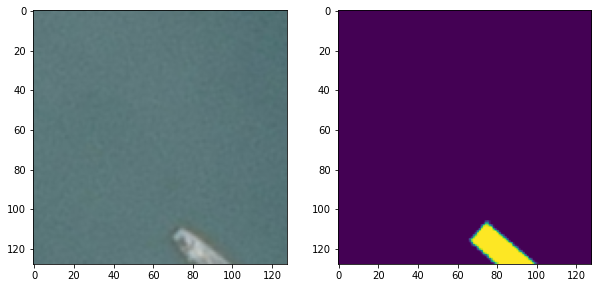

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for images, labels in dataset.take(1):
    images = images[0]
    labels = labels[0]
    ax[0] = ax[0].imshow(images)
    ax[1] = ax[1].imshow(labels)

In [109]:
from src.models.u_net import UNet_keras
seg_model = UNet_keras(edge_crop=EDGE_CROP, img_shape=IMG_SHAPE)

In [110]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,BinaryCrossentropy 

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [111]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="./saved_models/{}_weights.best.ctph".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=10, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=30) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, reduceLROnPlat, early]

step_count = min(MAX_TRAIN_STEPS, train_df_balanced.shape[0]//BATCH_SIZE)
loss_history = [seg_model.fit(dataset.repeat(N_REPEAT), 
                             epochs=NB_EPOCHS, 
                             validation_data=validation.take(1),
                             #callbacks=callbacks_list,
                              verbose=1,
                            workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/10


 79/469 [====>.........................] - ETA: 22:21 - loss: -0.0107 - dice_coef: 0.0115 - binary_accuracy: 0.0765 - true_positive_rate: 0.93 - ETA: 9:52 - loss: -0.0113 - dice_coef: 0.0121 - binary_accuracy: 0.0742 - true_positive_rate: 0.9310 - ETA: 10:39 - loss: -0.0110 - dice_coef: 0.0117 - binary_accuracy: 0.0708 - true_positive_rate: 0.93 - ETA: 11:07 - loss: -0.0106 - dice_coef: 0.0114 - binary_accuracy: 0.0676 - true_positive_rate: 0.93 - ETA: 11:04 - loss: -0.0105 - dice_coef: 0.0113 - binary_accuracy: 0.0657 - true_positive_rate: 0.93 - ETA: 11:21 - loss: -0.0105 - dice_coef: 0.0112 - binary_accuracy: 0.0642 - true_positive_rate: 0.93 - ETA: 11:13 - loss: -0.0103 - dice_coef: 0.0111 - binary_accuracy: 0.0631 - true_positive_rate: 0.93 - ETA: 11:15 - loss: -0.0101 - dice_coef: 0.0109 - binary_accuracy: 0.0622 - true_positive_rate: 0.93 - ETA: 11:19 - loss: -0.0101 - dice_coef: 0.0109 - binary_accuracy: 0.0616 - true_positive_rate: 0.93 - ETA: 11:26 - loss: -0.0102 - dice_coef

239/469 [==============>...............] - ETA: 7:47 - loss: -0.0115 - dice_coef: 0.0123 - binary_accuracy: 0.0604 - true_positive_rate: 0.947 - ETA: 7:45 - loss: -0.0115 - dice_coef: 0.0123 - binary_accuracy: 0.0608 - true_positive_rate: 0.947 - ETA: 7:43 - loss: -0.0115 - dice_coef: 0.0123 - binary_accuracy: 0.0612 - true_positive_rate: 0.947 - ETA: 7:42 - loss: -0.0115 - dice_coef: 0.0123 - binary_accuracy: 0.0617 - true_positive_rate: 0.947 - ETA: 7:40 - loss: -0.0115 - dice_coef: 0.0123 - binary_accuracy: 0.0621 - true_positive_rate: 0.946 - ETA: 7:39 - loss: -0.0115 - dice_coef: 0.0123 - binary_accuracy: 0.0626 - true_positive_rate: 0.946 - ETA: 7:37 - loss: -0.0115 - dice_coef: 0.0123 - binary_accuracy: 0.0631 - true_positive_rate: 0.946 - ETA: 7:36 - loss: -0.0116 - dice_coef: 0.0123 - binary_accuracy: 0.0635 - true_positive_rate: 0.946 - ETA: 7:34 - loss: -0.0116 - dice_coef: 0.0124 - binary_accuracy: 0.0640 - true_positive_rate: 0.945 - ETA: 7:33 - loss: -0.0116 - dice_coef: 

319/469 [===================>..........] - ETA: 5:47 - loss: -0.0123 - dice_coef: 0.0132 - binary_accuracy: 0.1133 - true_positive_rate: 0.909 - ETA: 5:45 - loss: -0.0123 - dice_coef: 0.0132 - binary_accuracy: 0.1141 - true_positive_rate: 0.908 - ETA: 5:44 - loss: -0.0124 - dice_coef: 0.0132 - binary_accuracy: 0.1149 - true_positive_rate: 0.907 - ETA: 5:43 - loss: -0.0124 - dice_coef: 0.0132 - binary_accuracy: 0.1157 - true_positive_rate: 0.907 - ETA: 5:41 - loss: -0.0124 - dice_coef: 0.0132 - binary_accuracy: 0.1165 - true_positive_rate: 0.906 - ETA: 5:39 - loss: -0.0124 - dice_coef: 0.0132 - binary_accuracy: 0.1174 - true_positive_rate: 0.905 - ETA: 5:38 - loss: -0.0124 - dice_coef: 0.0132 - binary_accuracy: 0.1182 - true_positive_rate: 0.905 - ETA: 5:36 - loss: -0.0124 - dice_coef: 0.0133 - binary_accuracy: 0.1190 - true_positive_rate: 0.904 - ETA: 5:35 - loss: -0.0124 - dice_coef: 0.0133 - binary_accuracy: 0.1198 - true_positive_rate: 0.903 - ETA: 5:33 - loss: -0.0124 - dice_coef: 

399/469 [========================>.....] - ETA: 3:46 - loss: -0.0137 - dice_coef: 0.0146 - binary_accuracy: 0.1811 - true_positive_rate: 0.850 - ETA: 3:45 - loss: -0.0137 - dice_coef: 0.0146 - binary_accuracy: 0.1820 - true_positive_rate: 0.849 - ETA: 3:43 - loss: -0.0138 - dice_coef: 0.0146 - binary_accuracy: 0.1828 - true_positive_rate: 0.849 - ETA: 3:42 - loss: -0.0138 - dice_coef: 0.0147 - binary_accuracy: 0.1837 - true_positive_rate: 0.848 - ETA: 3:40 - loss: -0.0138 - dice_coef: 0.0147 - binary_accuracy: 0.1845 - true_positive_rate: 0.847 - ETA: 3:39 - loss: -0.0138 - dice_coef: 0.0147 - binary_accuracy: 0.1854 - true_positive_rate: 0.846 - ETA: 3:37 - loss: -0.0139 - dice_coef: 0.0147 - binary_accuracy: 0.1862 - true_positive_rate: 0.846 - ETA: 3:36 - loss: -0.0139 - dice_coef: 0.0148 - binary_accuracy: 0.1871 - true_positive_rate: 0.845 - ETA: 3:34 - loss: -0.0139 - dice_coef: 0.0148 - binary_accuracy: 0.1879 - true_positive_rate: 0.844 - ETA: 3:33 - loss: -0.0140 - dice_coef: 

469/469 [==============================] - ETA: 1:45 - loss: -0.0178 - dice_coef: 0.0187 - binary_accuracy: 0.2472 - true_positive_rate: 0.788 - ETA: 1:43 - loss: -0.0179 - dice_coef: 0.0188 - binary_accuracy: 0.2480 - true_positive_rate: 0.787 - ETA: 1:42 - loss: -0.0180 - dice_coef: 0.0188 - binary_accuracy: 0.2487 - true_positive_rate: 0.786 - ETA: 1:40 - loss: -0.0180 - dice_coef: 0.0189 - binary_accuracy: 0.2495 - true_positive_rate: 0.785 - ETA: 1:39 - loss: -0.0181 - dice_coef: 0.0190 - binary_accuracy: 0.2503 - true_positive_rate: 0.785 - ETA: 1:37 - loss: -0.0182 - dice_coef: 0.0190 - binary_accuracy: 0.2511 - true_positive_rate: 0.784 - ETA: 1:36 - loss: -0.0182 - dice_coef: 0.0191 - binary_accuracy: 0.2519 - true_positive_rate: 0.783 - ETA: 1:34 - loss: -0.0183 - dice_coef: 0.0192 - binary_accuracy: 0.2526 - true_positive_rate: 0.782 - ETA: 1:32 - loss: -0.0184 - dice_coef: 0.0192 - binary_accuracy: 0.2534 - true_positive_rate: 0.781 - ETA: 1:31 - loss: -0.0185 - dice_coef: 

157/469 [=========>....................] - ETA: 19s - loss: -0.4008 - dice_coef: 0.4009 - binary_accuracy: 0.9923 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.3268 - dice_coef: 0.3269 - binary_accuracy: 0.9922 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2972 - dice_coef: 0.2973 - binary_accuracy: 0.9925 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2806 - dice_coef: 0.2807 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2765 - dice_coef: 0.2766 - binary_accuracy: 0.9928 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2727 - dice_coef: 0.2727 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2701 - dice_coef: 0.2702 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2687 - dice_coef: 0.2688 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2666 - dice_coef: 0.2667 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2

469/469 [==============================] - ETA: 4s - loss: -0.2571 - dice_coef: 0.2572 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2568 - dice_coef: 0.2569 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2566 - dice_coef: 0.2567 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2563 - dice_coef: 0.2564 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2560 - dice_coef: 0.2562 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2558 - dice_coef: 0.2559 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2555 - dice_coef: 0.2556 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2553 - dice_coef: 0.2554 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.2550 - dice_coef: 0.2551 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.25

Epoch 3/10


156/469 [========>.....................] - ETA: 12s - loss: -0.4008 - dice_coef: 0.4009 - binary_accuracy: 0.9923 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.3268 - dice_coef: 0.3269 - binary_accuracy: 0.9922 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2972 - dice_coef: 0.2973 - binary_accuracy: 0.9925 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2806 - dice_coef: 0.2807 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2765 - dice_coef: 0.2766 - binary_accuracy: 0.9928 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2727 - dice_coef: 0.2727 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2701 - dice_coef: 0.2702 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2687 - dice_coef: 0.2688 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2666 - dice_coef: 0.2667 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2

469/469 [==============================] - ETA: 4s - loss: -0.2572 - dice_coef: 0.2573 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2570 - dice_coef: 0.2571 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2567 - dice_coef: 0.2568 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2564 - dice_coef: 0.2565 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2562 - dice_coef: 0.2563 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2559 - dice_coef: 0.2560 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2557 - dice_coef: 0.2558 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2554 - dice_coef: 0.2555 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.2551 - dice_coef: 0.2552 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.25

Epoch 4/10


157/469 [=========>....................] - ETA: 14s - loss: -0.4008 - dice_coef: 0.4009 - binary_accuracy: 0.9923 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.3268 - dice_coef: 0.3269 - binary_accuracy: 0.9922 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2972 - dice_coef: 0.2973 - binary_accuracy: 0.9925 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2806 - dice_coef: 0.2807 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2765 - dice_coef: 0.2766 - binary_accuracy: 0.9928 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2727 - dice_coef: 0.2727 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2701 - dice_coef: 0.2702 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2687 - dice_coef: 0.2688 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2666 - dice_coef: 0.2667 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2

469/469 [==============================] - ETA: 4s - loss: -0.2571 - dice_coef: 0.2572 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2568 - dice_coef: 0.2569 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2566 - dice_coef: 0.2567 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2563 - dice_coef: 0.2564 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2560 - dice_coef: 0.2562 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2558 - dice_coef: 0.2559 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2555 - dice_coef: 0.2556 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2553 - dice_coef: 0.2554 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.2550 - dice_coef: 0.2551 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.25

Epoch 5/10


157/469 [=========>....................] - ETA: 16s - loss: -0.4008 - dice_coef: 0.4009 - binary_accuracy: 0.9923 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.3268 - dice_coef: 0.3269 - binary_accuracy: 0.9922 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2972 - dice_coef: 0.2973 - binary_accuracy: 0.9925 - true_positive_rate: 0.0000e+ - ETA: 14s - loss: -0.2806 - dice_coef: 0.2807 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2765 - dice_coef: 0.2766 - binary_accuracy: 0.9928 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2727 - dice_coef: 0.2727 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2701 - dice_coef: 0.2702 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2687 - dice_coef: 0.2688 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2666 - dice_coef: 0.2667 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2

469/469 [==============================] - ETA: 4s - loss: -0.2571 - dice_coef: 0.2572 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2568 - dice_coef: 0.2569 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2566 - dice_coef: 0.2567 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2563 - dice_coef: 0.2564 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2560 - dice_coef: 0.2562 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2558 - dice_coef: 0.2559 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2555 - dice_coef: 0.2556 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2553 - dice_coef: 0.2554 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.2550 - dice_coef: 0.2551 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.25

Epoch 6/10


157/469 [=========>....................] - ETA: 16s - loss: -0.4008 - dice_coef: 0.4009 - binary_accuracy: 0.9923 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.3268 - dice_coef: 0.3269 - binary_accuracy: 0.9922 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2972 - dice_coef: 0.2973 - binary_accuracy: 0.9925 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2806 - dice_coef: 0.2807 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2765 - dice_coef: 0.2766 - binary_accuracy: 0.9928 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2727 - dice_coef: 0.2727 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2701 - dice_coef: 0.2702 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2687 - dice_coef: 0.2688 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2666 - dice_coef: 0.2667 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2

469/469 [==============================] - ETA: 4s - loss: -0.2571 - dice_coef: 0.2572 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2568 - dice_coef: 0.2569 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2566 - dice_coef: 0.2567 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2563 - dice_coef: 0.2564 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2560 - dice_coef: 0.2562 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2558 - dice_coef: 0.2559 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2555 - dice_coef: 0.2556 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.2553 - dice_coef: 0.2554 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.2550 - dice_coef: 0.2551 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.25

Epoch 7/10


147/469 [========>.....................] - ETA: 14s - loss: -0.4008 - dice_coef: 0.4009 - binary_accuracy: 0.9923 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.3268 - dice_coef: 0.3269 - binary_accuracy: 0.9922 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2972 - dice_coef: 0.2973 - binary_accuracy: 0.9925 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2806 - dice_coef: 0.2807 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2765 - dice_coef: 0.2766 - binary_accuracy: 0.9928 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2727 - dice_coef: 0.2727 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2701 - dice_coef: 0.2702 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2687 - dice_coef: 0.2688 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2666 - dice_coef: 0.2667 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2

462/469 [============================>.] - ETA: 5s - loss: -0.2584 - dice_coef: 0.2585 - binary_accuracy: 0.9914 - true_positive_rate: 0.0000e+0 - ETA: 5s - loss: -0.2582 - dice_coef: 0.2583 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2579 - dice_coef: 0.2580 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2576 - dice_coef: 0.2577 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2574 - dice_coef: 0.2575 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2571 - dice_coef: 0.2572 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2568 - dice_coef: 0.2569 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2566 - dice_coef: 0.2567 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2563 - dice_coef: 0.2564 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.25

469/469 [==============================] - ETA: 0s - loss: -0.2400 - dice_coef: 0.2401 - binary_accuracy: 0.9909 - true_positive_rate: 0.0000e+0 - ETA: 0s - loss: -0.2398 - dice_coef: 0.2399 - binary_accuracy: 0.9908 - true_positive_rate: 0.0000e+0 - ETA: 0s - loss: -0.2396 - dice_coef: 0.2397 - binary_accuracy: 0.9908 - true_positive_rate: 0.0000e+0 - 15s 32ms/step - loss: -0.2394 - dice_coef: 0.2395 - binary_accuracy: 0.9908 - true_positive_rate: 0.0000e+00 - val_loss: -0.1272 - val_dice_coef: 0.1272 - val_binary_accuracy: 0.9960 - val_true_positive_rate: 0.0000e+00
Epoch 8/10


157/469 [=========>....................] - ETA: 13s - loss: -0.4008 - dice_coef: 0.4009 - binary_accuracy: 0.9923 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.3268 - dice_coef: 0.3269 - binary_accuracy: 0.9922 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2972 - dice_coef: 0.2973 - binary_accuracy: 0.9925 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2806 - dice_coef: 0.2807 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2765 - dice_coef: 0.2766 - binary_accuracy: 0.9928 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2727 - dice_coef: 0.2727 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2701 - dice_coef: 0.2702 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2687 - dice_coef: 0.2688 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2666 - dice_coef: 0.2667 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2

469/469 [==============================] - ETA: 4s - loss: -0.2571 - dice_coef: 0.2572 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2568 - dice_coef: 0.2569 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2566 - dice_coef: 0.2567 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2563 - dice_coef: 0.2564 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2560 - dice_coef: 0.2562 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2558 - dice_coef: 0.2559 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2555 - dice_coef: 0.2556 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2553 - dice_coef: 0.2554 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.2550 - dice_coef: 0.2551 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.25

Epoch 9/10


157/469 [=========>....................] - ETA: 13s - loss: -0.4008 - dice_coef: 0.4009 - binary_accuracy: 0.9923 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.3268 - dice_coef: 0.3269 - binary_accuracy: 0.9922 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2972 - dice_coef: 0.2973 - binary_accuracy: 0.9925 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2806 - dice_coef: 0.2807 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2765 - dice_coef: 0.2766 - binary_accuracy: 0.9928 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2727 - dice_coef: 0.2727 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2701 - dice_coef: 0.2702 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2687 - dice_coef: 0.2688 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2666 - dice_coef: 0.2667 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2

469/469 [==============================] - ETA: 4s - loss: -0.2571 - dice_coef: 0.2572 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2568 - dice_coef: 0.2569 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2566 - dice_coef: 0.2567 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2563 - dice_coef: 0.2564 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2560 - dice_coef: 0.2562 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2558 - dice_coef: 0.2559 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2555 - dice_coef: 0.2556 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2553 - dice_coef: 0.2554 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.2550 - dice_coef: 0.2551 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.25

Epoch 10/10


157/469 [=========>....................] - ETA: 16s - loss: -0.4008 - dice_coef: 0.4009 - binary_accuracy: 0.9923 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.3268 - dice_coef: 0.3269 - binary_accuracy: 0.9922 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2972 - dice_coef: 0.2973 - binary_accuracy: 0.9925 - true_positive_rate: 0.0000e+ - ETA: 13s - loss: -0.2806 - dice_coef: 0.2807 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2765 - dice_coef: 0.2766 - binary_accuracy: 0.9928 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2727 - dice_coef: 0.2727 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2701 - dice_coef: 0.2702 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2687 - dice_coef: 0.2688 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2666 - dice_coef: 0.2667 - binary_accuracy: 0.9927 - true_positive_rate: 0.0000e+ - ETA: 12s - loss: -0.2

469/469 [==============================] - ETA: 4s - loss: -0.2572 - dice_coef: 0.2573 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2570 - dice_coef: 0.2571 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2567 - dice_coef: 0.2568 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2564 - dice_coef: 0.2565 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2562 - dice_coef: 0.2563 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2559 - dice_coef: 0.2560 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2557 - dice_coef: 0.2558 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2554 - dice_coef: 0.2555 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 4s - loss: -0.2551 - dice_coef: 0.2552 - binary_accuracy: 0.9913 - true_positive_rate: 0.0000e+0 - ETA: 3s - loss: -0.25

In [112]:
import pickle

timestamp = time.strftime("%Y%m%d-%H%M%S")


export_dir = './saved_models/segm_full_{}_{}'.format(N_SAMPLE, timestamp)
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(seg_model, export_dir)


# in two lines of code
with open(f"./saved_models/segm_full_{N_SAMPLE}_{timestamp}/loss.pickle", "wb") as f:
    print('Exporting to {}/loss.pickle'.format(export_dir))
    pickle.dump(loss_history[0].history, f)


Exporting to ./saved_models/segm_full_500_20220627-151025
INFO:tensorflow:Assets written to: ./saved_models/segm_full_500_20220627-151025\assets
Exporting to ./saved_models/segm_full_500_20220627-151025/loss.pickle


In [115]:
from tensorflow import keras

model_eval = tf.keras.model.load_model('./saved_models/segm_full_500_20220627-151025')
print(model_eval)
print(seg_model)
#result = model_eval.evaluate(validation)

AttributeError: module 'tensorflow.keras' has no attribute 'model'

In [116]:
with open(f"./saved_models/segm_full_{N_SAMPLE}_{timestamp}/loss.pickle", 'rb') as f:
    loss_record = pickle.load(f)

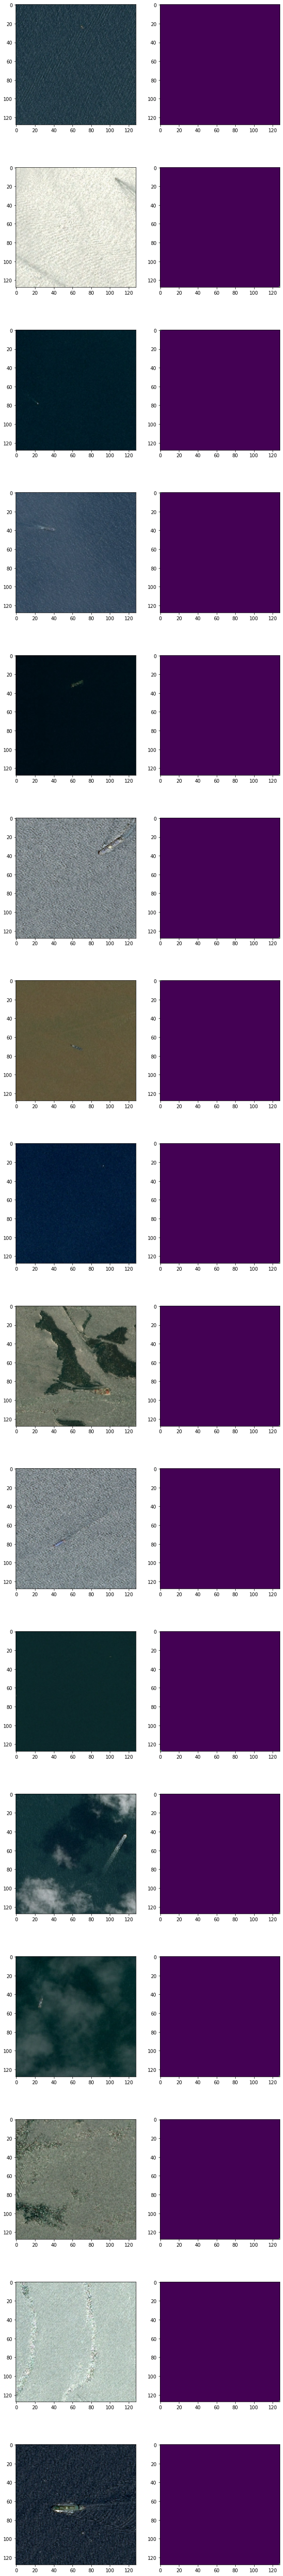

In [117]:
fig, axs = plt.subplots(BATCH_SIZE, 2, figsize=(10, 100))

preview = validation

for images, labels in preview.take(1):
    for i in range(BATCH_SIZE):
        ax = axs[i]
        image = images[i]
        label = labels[i]
        ax[0] = ax[0].imshow(image)
        ax[1] = ax[1].imshow(seg_model.predict(preview.take(1))[i])

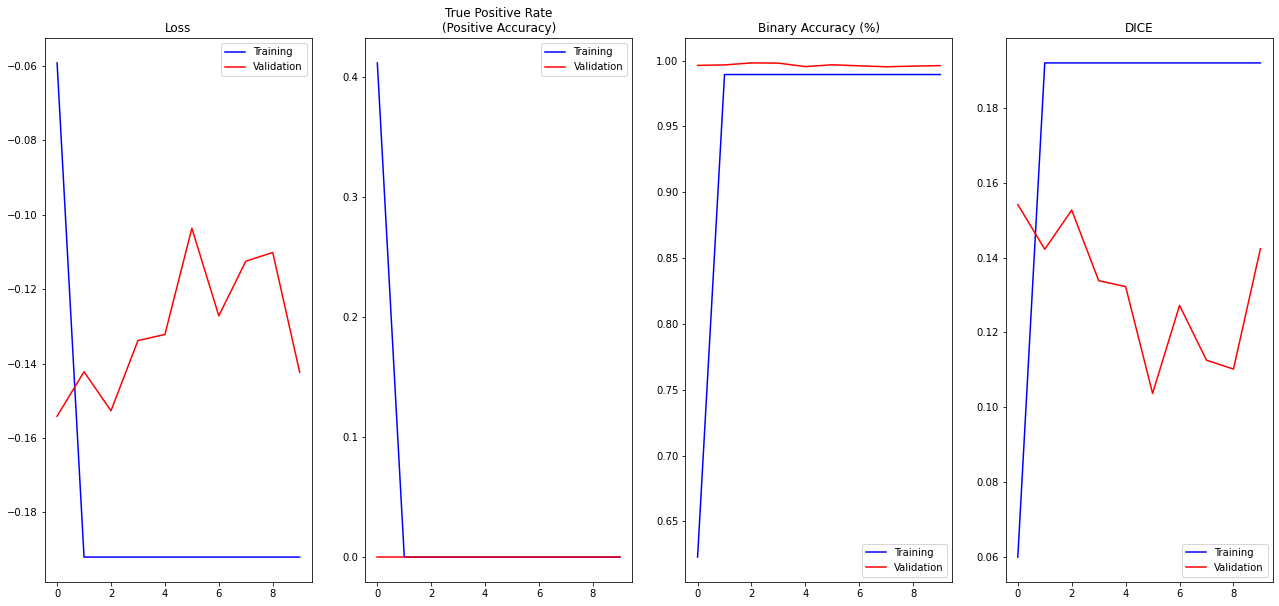

In [118]:
def show_loss(loss_record):
    epich = [i for i in range(len(loss_record['loss']))]
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([loss_record['loss']]),
                 'b-',
                 epich, np.concatenate(
            [loss_record['val_loss']]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [loss_record['true_positive_rate']]), 'b-',
                     epich, np.concatenate(
            [loss_record['val_true_positive_rate']]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [loss_record['binary_accuracy']]), 'b-',
                     epich, np.concatenate(
            [loss_record['val_binary_accuracy']]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [loss_record['dice_coef']]), 'b-',
                     epich, np.concatenate(
            [loss_record['val_dice_coef']]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_record)